# SCHEMA
INPUT is board state 
OUTPUT is concept vector 

In [23]:
# A pipeline to walk through stuff 
from alphazero.games.othello import OthelloBoard, OthelloNet
from alphazero.players import AlphaZeroPlayer, MCTSPlayer

In [24]:
import numpy as np
from src.datasets.datasets import load_kaggle_othello_games

cfg = {
    'board_size': 8,
    'n_positions': 100,      # ~100 games × ~80 moves; loader caps at this
    'min_move_number': 1,     # skip opening
    'max_move_number': 2,    # include late game (standard Othello ~60 moves)
    'seed': 42,
}

positions = load_kaggle_othello_games(cfg)
print(f"Loaded {len(positions)} positions")
pos = positions[10]


Loading Kaggle Othello dataset...
Loaded 25657 games from Kaggle

Collection statistics:
  Total games processed: 50
  Successful parses: 50 (100.0%)
  No positions in range [1,2]: 0
  Parse failures: 0
  Too short: 0
  Total positions collected: 100
Loaded 100 positions


In [25]:
board_size = 8 
board = OthelloBoard(n=board_size)
board.grid = pos['grid'].copy()
board.player = pos['player']

In [26]:
name = 'alphazero-othello-8'
checkpoint = 'models/'
net = OthelloNet.from_pretrained(name, checkpoint)
player = AlphaZeroPlayer(nn=net, n_sim=10000)

In [27]:
board_snapshot = board.clone()

In [28]:
# Step 2: Run MCTS on the board (this fills the tree)
move, action_probs, visit_counts, prior_probs = player.get_move(board)
mct = player.mct

print(f"Root had {len(mct.root.children)} children. Best move chosen: {move}")
print(f"Visit counts at root: {visit_counts}")

Root had 3 children. Best move chosen: (2, 4)
Visit counts at root: {(2, 4): 9827, (4, 2): 147, (2, 2): 26}


# VIZ

In [29]:
from src.hooks.extract import get_single_activation

def get_full_decision_tree_recursive(mct, board, max_depth, layer_name, sort_key="N"):
    """
    Builds a 'spine' tree:
    -  Main path (best moves) spawns second-best alternatives at each level
    - Second-best branches only follow their own best moves (no further branching)
    """
    from alphazero.games.othello import OthelloBoard
    n = board.n
    levels = [[] for _ in range(max_depth + 1)]
    
    gid_counter = 0 
    
    def walk(node, board_state, depth, label, move, idx, is_main_path):
        nonlocal gid_counter

        if depth > max_depth:
            return
        
        act = get_single_activation(net, board_state.grid.copy(), board_state.player, layer_name)

        # Ensure list is long enough
        while len(levels[depth]) <= idx:
            levels[depth].append(None)
        
        levels[depth][idx] = {
            "grid": board_state.grid.copy(),
            "player": board_state.player,
            "move": move,
            "label": label,
            "n_children": len(node.children),
            "N": getattr(node, 'N', None),
            "Q": getattr(node, 'Q', None),
            "_mct_node": node,
            "depth": depth,
            "activations": act,
            "main": is_main_path,
            "id": gid_counter
        }
        gid_counter += 1
        
        if not node.children:
            return
            
        items = sorted(node.children.items(), 
                      key=lambda x: getattr(x[1], sort_key), reverse=True)
        
        # Best child - always follow it
        best_move, best_node = items[0]
        b_best = board_state.clone()
        b_best.play_move(best_move)
        walk(best_node, b_best, depth + 1, "best", best_move, 2 * idx, is_main_path)
        
        # Second-best child - ONLY if we're on the main path
        if len(items) >= 2 and is_main_path:
            second_move, second_node = items[1]
            b_second = board_state.clone()
            b_second.play_move(second_move)
            # Pass is_main_path=False so this branch won't spawn more second-bests
            walk(second_node, b_second, depth + 1, "2nd", second_move, 2 * idx + 1, False)
    
    walk(mct.root, board.clone(), 0, "root", None, 0, True)
    return levels

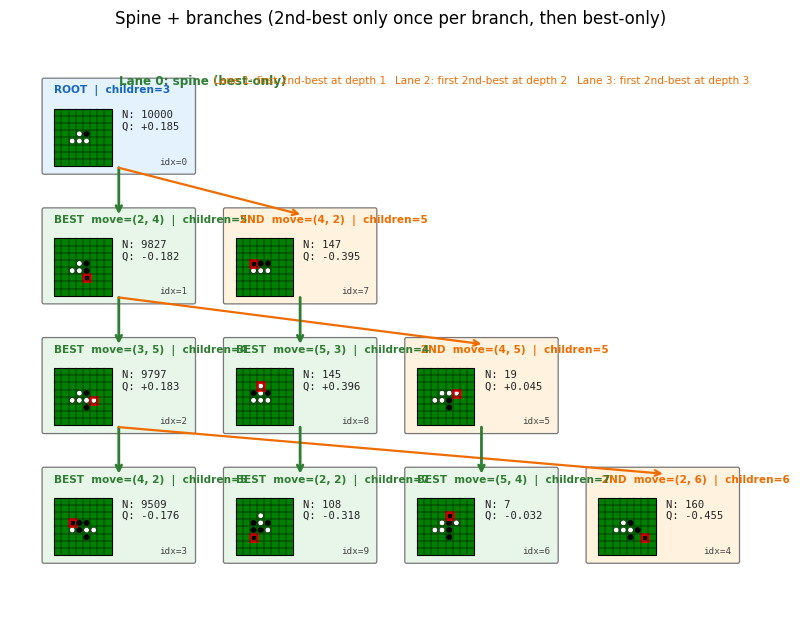

In [30]:
def visualize_spine_decision_tree(levels, n, board_scale=1.0):
    """
    Spine + branches visualization that scales to larger max_depth.

    Layout idea:
    - Lane 0: the main (all-left / best-only) spine.
    - Lane k (k>=1): nodes whose FIRST right-turn (second-best) occurs at depth k.
      (Computed from idx's binary path bits for that depth.)
    - This keeps width O(max_depth) rather than O(2^max_depth).

    Assumes heap-style indexing:
      parent (d, idx) -> children (d+1, 2*idx) [best/left], (d+1, 2*idx+1) [second/right]
    """

    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from alphazero.games.othello import OthelloBoard

    max_depth = len(levels) - 1

    # ---- Collect nodes ----
    node_positions = {}
    for d, level in enumerate(levels):
        for idx, info in enumerate(level):
            if info is not None:
                node_positions[(d, idx)] = info

    if not node_positions:
        print("No nodes to visualize.")
        return

    # ---- Lane assignment ----
    # lane = 0 if path bits are all 0; else lane = position (1..d) of first '1' in MSB->LSB path bits.
    def lane_for(d, idx):
        if d == 0:
            return 0
        # idx in [0, 2^d). Represent with d bits.
        bits = f"{idx:0{d}b}"  # MSB first
        first_one = bits.find("1")
        return 0 if first_one == -1 else (first_one + 1)  # +1 => lanes 1..d

    lane = {(d, idx): lane_for(d, idx) for (d, idx) in node_positions.keys()}
    max_lane = max(lane.values())  # <= max_depth

    # ---- Layout parameters (tuned to scale) ----
    # Board "card" dimensions in *data coords*
    board_size = 1.0 * board_scale
    meta_w = 1.25 * board_scale          # width of metadata panel
    pad = 0.18 * board_scale             # padding around board/meta inside card
    card_w = board_size + meta_w + 2 * pad
    card_h = board_size + 2 * pad + 0.25 * board_scale   # extra top space for title line

    lane_gap = 0.55 * board_scale        # gap between lanes
    depth_gap = 0.65 * board_scale       # gap between rows
    x_step = card_w + lane_gap
    y_step = card_h + depth_gap

    # ---- Compute node centers (x,y) ----
    # Put depth 0 at top => y increases downward, then invert axis at end (or compute reversed).
    xy = {}
    for (d, idx) in node_positions.keys():
        L = lane[(d, idx)]
        cx = L * x_step
        cy = d * y_step
        xy[(d, idx)] = (cx, cy)

    # ---- Figure sizing ----
    # Convert data coords -> inches roughly: we pick figsize based on number of lanes / depth.
    fig_w = max(8, (max_lane + 1) * (2.2 * board_scale))
    fig_h = max(8, (max_depth + 1) * (1.75 * board_scale))

    fig, ax = plt.subplots(figsize=(fig_w, fig_h))
    ax.set_xlim(-x_step * 0.6, (max_lane + 1) * x_step - x_step * 0.4)
    ax.set_ylim(-y_step * 0.6, (max_depth + 1) * y_step - y_step * 0.2)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.invert_yaxis()  # depth 0 at top

    # ---- Drawing helpers ----
    def draw_card(cx, cy, info, is_root=False):
        grid = info["grid"]
        move = info["move"]
        label = info["label"]
        n_ch = info["n_children"]
        N = info.get("N")
        Q = info.get("Q")

        # Colors
        if is_root:
            bg = "#e3f2fd"
            accent = "#1565c0"
        elif label == "best":
            bg = "#e8f5e9"
            accent = "#2e7d32"
        else:
            bg = "#fff3e0"
            accent = "#ef6c00"

        # Card origin
        left = cx - card_w / 2
        top = cy - card_h / 2

        # Card box
        card = patches.FancyBboxPatch(
            (left, top),
            card_w, card_h,
            boxstyle="round,pad=0.03",
            facecolor=bg, edgecolor="#777777", linewidth=0.9
        )
        ax.add_patch(card)

        # Title line (top-left inside card)
        if is_root:
            title = f"ROOT  |  children={n_ch}"
        else:
            title = f"{label.upper():>4}  move={move}  |  children={n_ch}"
        ax.text(
            left + pad, top + 0.18 * board_scale,
            title,
            ha="left", va="center",
            fontsize=8 * board_scale, fontweight="bold", color=accent
        )

        # Board region
        board_left = left + pad
        board_top = top + 0.32 * board_scale + pad
        board_bottom = board_top
        # board rectangle (we draw from top-left using bottom coords)
        board_y = board_top
        board_x = board_left

        # Board background
        ax.add_patch(
            patches.Rectangle(
                (board_x, board_y),
                board_size, board_size,
                facecolor=OthelloBoard.COLORS[0], edgecolor="black", linewidth=0.8
            )
        )

        # Grid lines
        cell = board_size / n
        for i in range(1, n):
            ax.plot([board_x + i * cell, board_x + i * cell], [board_y, board_y + board_size], "k-", lw=0.35)
            ax.plot([board_x, board_x + board_size], [board_y + i * cell, board_y + i * cell], "k-", lw=0.35)

        # Pieces + highlight
        r = cell * 0.38
        for row in range(n):
            for col in range(n):
                v = grid[row, col]
                if v != 0:
                    px = board_x + col * cell + cell / 2
                    py = board_y + (n - 1 - row) * cell + cell / 2
                    ax.add_patch(
                        patches.Circle((px, py), r,
                                       facecolor=OthelloBoard.COLORS[v],
                                       edgecolor="black", linewidth=0.35)
                    )
                if move == (row, col):
                    hx = board_x + col * cell
                    hy = board_y + (n - 1 - row) * cell
                    ax.add_patch(
                        patches.Rectangle((hx, hy), cell, cell,
                                          fill=False, edgecolor="red", linewidth=1.8)
                    )

        # Metadata panel (right side)
        meta_left = board_x + board_size + pad
        meta_top = board_y + 0.02 * board_scale

        # Nicely formatted stats (monospace so it lines up)
        lines = []
        if N is not None:
            lines.append(f"N: {N:.0f}")
        if Q is not None:
            lines.append(f"Q: {Q:+.3f}")
        # Add more fields if present
        if "P" in info:
            lines.append(f"P: {info['P']:.3f}")
        if "U" in info:
            lines.append(f"U: {info['U']:.3f}")

        meta_text = "\n".join(lines) if lines else "(no stats)"
        ax.text(
            meta_left, meta_top,
            meta_text,
            ha="left", va="top",
            fontsize=8 * board_scale,
            family="monospace",
            color="#222222"
        )

        idx = info.get("id")
        if idx is not None:
            ax.text(
                left + card_w - pad * 0.6,
                top + card_h - pad * 0.6,
                f"idx={idx}",
                ha="right",
                va="bottom",
                fontsize=7 * board_scale,
                family="monospace",
                color="#444444"
            )


    def draw_arrow(p_xy, c_xy, is_best):
        # Slightly offset arrow to reduce overlap with cards
        (px, py) = p_xy
        (cx, cy) = c_xy

        # Arrow from bottom center of parent card to top center of child card
        start = (px, py + card_h * 0.45)
        end = (cx, cy - card_h * 0.45)

        color = "#2e7d32" if is_best else "#ef6c00"
        lw = 2.0 if is_best else 1.6

        ax.annotate(
            "", xy=end, xytext=start,
            arrowprops=dict(arrowstyle="->", color=color, lw=lw, shrinkA=0, shrinkB=0)
        )

    # ---- Draw edges first (so cards sit on top) ----
    for (d, idx), info in node_positions.items():
        if d >= max_depth:
            continue
        parent = (d, idx)
        for k, child_idx in enumerate([2 * idx, 2 * idx + 1]):
            child = (d + 1, child_idx)
            if child not in node_positions:
                continue
            # k==0 => best/left, k==1 => second/right
            draw_arrow(xy[parent], xy[child], is_best=(k == 0))

    # ---- Draw nodes ----
    for (d, idx), info in node_positions.items():
        cx, cy = xy[(d, idx)]
        draw_card(cx, cy, info, is_root=(d == 0))


    # ---- Lane labels (helpful when depth gets big) ----
    ax.text(0, -0.35 * y_step, "Lane 0: spine (best-only)", ha="left", va="center",
            fontsize=9 * board_scale, color="#2e7d32", fontweight="bold")
    for L in range(1, max_lane + 1):
        ax.text(L * x_step, -0.35 * y_step, f"Lane {L}: first 2nd-best at depth {L}",
                ha="center", va="center", fontsize=8 * board_scale, color="#ef6c00")

    plt.title("Spine + branches (2nd-best only once per branch, then best-only)", fontsize=12, pad=18)
    plt.tight_layout()
    
    plt.show()

full_tree_max_depth = 3  # try bigger
full_levels = get_full_decision_tree_recursive(mct, board_snapshot, max_depth=full_tree_max_depth, layer_name="bn2")
visualize_spine_decision_tree(full_levels, board_snapshot.n, board_scale=0.95)

In [31]:
pairs = []

for d, level in enumerate(full_levels): 
    main = level[0] # main branch at that depth 
    
    m_node = {k: main[k] for k in ["id", "activations"]}

    for n in level[1:]: # make and add to pairs 
        if not n: 
            continue 
        n_node = {k: n[k] for k in ["id", "activations"]}
        
        pairs.append((m_node, n_node))

pairs

[({'id': 1,
   'activations': array([ 1.5122645,  0.9175745,  0.8845391, ..., -1.3584661, -1.3584661,
          -1.3152348], shape=(2048,), dtype=float32)},
  {'id': 7,
   'activations': array([ 1.5122645,  0.9175745,  0.9175745, ..., -1.3584661, -1.3584661,
          -1.3152348], shape=(2048,), dtype=float32)}),
 ({'id': 2,
   'activations': array([ 1.5122645 ,  0.9175745 ,  0.92820644, ..., -1.3584661 ,
          -1.3584661 , -1.3152348 ], shape=(2048,), dtype=float32)},
  {'id': 5,
   'activations': array([ 1.5122645 ,  0.9175745 ,  0.92820644, ..., -1.3584661 ,
          -1.3584661 , -1.3152348 ], shape=(2048,), dtype=float32)}),
 ({'id': 2,
   'activations': array([ 1.5122645 ,  0.9175745 ,  0.92820644, ..., -1.3584661 ,
          -1.3584661 , -1.3152348 ], shape=(2048,), dtype=float32)},
  {'id': 8,
   'activations': array([ 1.5122645,  0.9175745,  0.9175745, ..., -1.3539854, -1.3584661,
          -1.3152348], shape=(2048,), dtype=float32)}),
 ({'id': 3,
   'activations': array([

In [32]:
full_levels

[[{'grid': array([[-0., -0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -1., -1., -1., -0., -0., -0.],
          [-0., -0., -0., -1.,  1., -0., -0., -0.],
          [-0., -0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -0., -0., -0., -0.]], dtype=float32),
   'player': 1,
   'move': None,
   'label': 'root',
   'n_children': 3,
   'N': 10000,
   'Q': 0.18529098378668463,
   '_mct_node': <alphazero.mcts.Node at 0x117287e30>,
   'depth': 0,
   'activations': array([ 1.5122645,  0.9175745,  0.9175745, ..., -1.3584661, -1.3584661,
          -1.3152348], shape=(2048,), dtype=float32),
   'main': True,
   'id': 0}],
 [{'grid': array([[-0., -0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0., -0., -0., -0., -0.],
          [-0., -0., -0., -0.,  1., -0., -0., -0.],
          [-0., -0., -1., -1.,  1.

In [33]:
import cvxpy as cp
import numpy as np

def find_concept_vector_from_pairs(
    Z_plus: np.ndarray,     # (m, dim)
    Z_minus: np.ndarray,    # (m, dim)
    margin: float = 0.0,
    l1: float = 1.0,        # sparsity weight
    l2: float = 0.0,        # stability weight
) -> np.ndarray:
    m, dim = Z_plus.shape
    assert Z_minus.shape == (m, dim)

    v = cp.Variable(dim)

    # Vectorized constraints: one per row
    constraints = [Z_plus @ v >= Z_minus @ v + margin]

    objective = l1 * cp.norm1(v)
    if l2 > 0:
        objective += l2 * cp.sum_squares(v)

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)

    return v.value

In [34]:
def find_concept_vector_soft_margin(
    Z_plus,
    Z_minus,
    margin=1.0,
    C=1.0,
    l2=1e-3,
):
    Z_plus = np.asarray(Z_plus)
    Z_minus = np.asarray(Z_minus)
    m, dim = Z_plus.shape

    v = cp.Variable(dim)
    xi = cp.Variable(m, nonneg=True)  # slack

    constraints = [
        Z_plus @ v >= Z_minus @ v + margin - xi
    ]

    objective = (
        C * cp.sum(xi) +
        l2 * cp.sum_squares(v)
    )

    prob = cp.Problem(cp.Minimize(objective), constraints)
    prob.solve(solver=cp.ECOS)

    return v.value


In [35]:
pairs

Z_plus = []
Z_minus = []

for x,y in pairs: 
    print(x['id'], y['id'])
    Z_plus.append(x['activations'])
    Z_minus.append(y['activations'])

1 7
2 5
2 8
3 4
3 6
3 9


In [36]:
import torch
v = find_concept_vector_from_pairs(torch.tensor(Z_plus), torch.tensor(Z_minus))
v

/var/folders/24/njx_3v7n0nj9kkzrv028sllm0000gn/T/ipykernel_80197/2646008557.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:256.)
  v = find_concept_vector_from_pairs(torch.tensor(Z_plus), torch.tensor(Z_minus))


array([ 2.38174242e-17,  4.42819887e-17, -4.84198840e-17, ...,
        2.25381174e-17, -2.51414568e-18, -3.48723658e-29], shape=(2048,))

Constraint satisfaction rate: 100.0%  (p >= m + margin)
Mean(p)=10.199, Mean(m)=-2.085, Mean(p-m)=12.285
Median(p-m)=12.148, 5th perc(p-m)=7.148
Projection-threshold balanced acc (heuristic): 91.7%  at thr=4.057


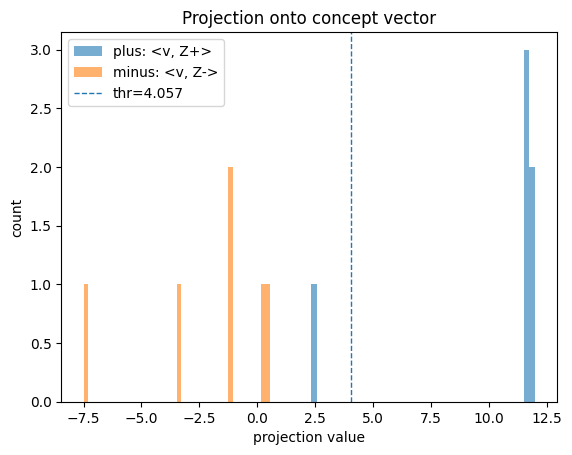

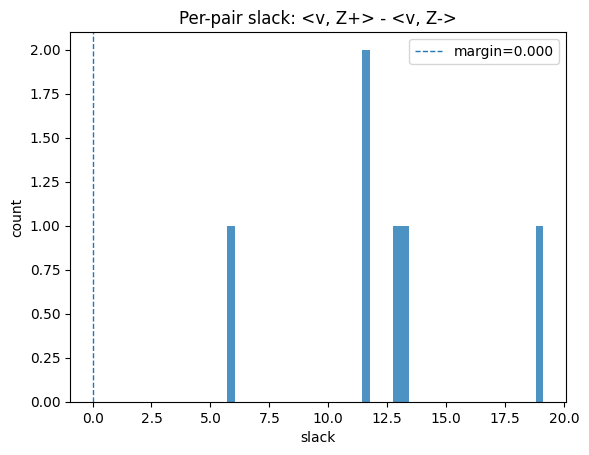

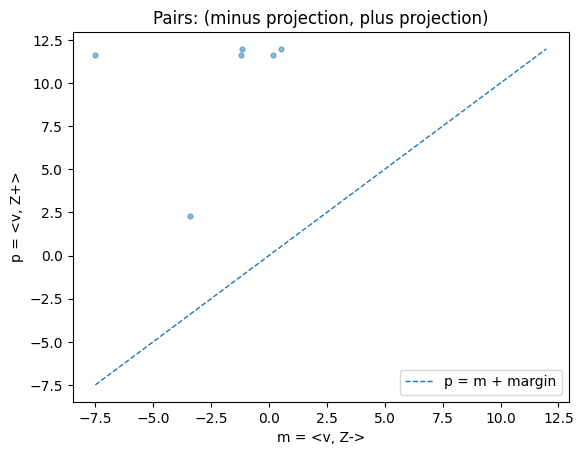

In [37]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pair_separation(Z_plus, Z_minus, v, margin=0.0, title="Projection onto concept vector"):
    """
    Visualize how well v separates Z_plus vs Z_minus via 1D projections.
    Also reports constraint satisfaction rate and a few summary stats.
    """
    # Accept torch tensors or numpy arrays
    if hasattr(Z_plus, "detach"):
        Z_plus = Z_plus.detach().cpu().numpy()
    if hasattr(Z_minus, "detach"):
        Z_minus = Z_minus.detach().cpu().numpy()
    if hasattr(v, "detach"):
        v = v.detach().cpu().numpy()

    Z_plus = np.asarray(Z_plus)
    Z_minus = np.asarray(Z_minus)
    v = np.asarray(v).reshape(-1)

    # Guardrails
    assert Z_plus.shape == Z_minus.shape, (Z_plus.shape, Z_minus.shape)
    assert Z_plus.shape[1] == v.shape[0], (Z_plus.shape, v.shape)

    # Normalize v for nicer, scale-invariant plots (optional but recommended)
    v_norm = np.linalg.norm(v)
    if v_norm > 0:
        v = v / v_norm

    # Projections
    p = Z_plus @ v
    m = Z_minus @ v
    d = p - m  # per-pair margin slack

    # Metrics
    satisfied = d >= margin
    sat_rate = satisfied.mean()

    # A simple threshold classifier on projection:
    # Pick threshold halfway between the means (quick-and-dirty)
    thr = 0.5 * (p.mean() + m.mean())
    acc = 0.5 * ((p >= thr).mean() + (m < thr).mean())

    print(f"Constraint satisfaction rate: {sat_rate*100:.1f}%  (p >= m + margin)")
    print(f"Mean(p)={p.mean():.3f}, Mean(m)={m.mean():.3f}, Mean(p-m)={d.mean():.3f}")
    print(f"Median(p-m)={np.median(d):.3f}, 5th perc(p-m)={np.percentile(d,5):.3f}")
    print(f"Projection-threshold balanced acc (heuristic): {acc*100:.1f}%  at thr={thr:.3f}")

    # ---- Plot 1: overlaid histograms of projections ----
    plt.figure()
    plt.hist(p, bins=40, alpha=0.6, label="plus: <v, Z+>")
    plt.hist(m, bins=40, alpha=0.6, label="minus: <v, Z->")
    plt.axvline(thr, linestyle="--", linewidth=1, label=f"thr={thr:.3f}")
    plt.title(title)
    plt.xlabel("projection value")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    # ---- Plot 2: per-pair slack distribution ----
    plt.figure()
    plt.hist(d, bins=40, alpha=0.8)
    plt.axvline(margin, linestyle="--", linewidth=1, label=f"margin={margin:.3f}")
    plt.title("Per-pair slack: <v, Z+> - <v, Z->")
    plt.xlabel("slack")
    plt.ylabel("count")
    plt.legend()
    plt.show()

    # ---- Plot 3: scatter of pair projections (p vs m) ----
    plt.figure()
    plt.scatter(m, p, s=12, alpha=0.5)
    # Line p = m + margin (above this line = satisfied)
    lo = min(m.min(), p.min())
    hi = max(m.max(), p.max())
    xs = np.linspace(lo, hi, 200)
    plt.plot(xs, xs + margin, linestyle="--", linewidth=1, label="p = m + margin")
    plt.title("Pairs: (minus projection, plus projection)")
    plt.xlabel("m = <v, Z->")
    plt.ylabel("p = <v, Z+>")
    plt.legend()
    plt.show()

# Example usage with your lists:
Z_plus_np = np.stack(Z_plus)   # if Z_plus is a list
Z_minus_np = np.stack(Z_minus)
# v = find_concept_vector_from_pairs(Z_plus_np, Z_minus_np, margin=0.0, l1=1.0, l2=0.0)
plot_pair_separation(Z_plus_np, Z_minus_np, v, margin=0.0)
